## Using Long Short Term Memory (LSTM) model to predict the closing price of a company using the past 60 day stock price data.

In [1]:
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import datetime as dt
plt.style.use('fivethirtyeight')

In [2]:
#Getting stock quote
company = 'TSLA'
start = dt.datetime(2020, 3, 11)
end = dt.datetime(2021, 3, 11)

df = web.DataReader(company, 'yahoo', start, end)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-10,133.600006,121.599998,131.886002,129.065994,77972000.0,129.065994
2020-03-11,130.716003,122.599998,128.039993,126.846001,66612500.0,126.846001
2020-03-12,118.900002,109.250000,116.178001,112.110001,94545500.0,112.110001
2020-03-13,121.514000,100.400002,119.000000,109.323997,113201500.0,109.323997
2020-03-16,98.973999,88.433998,93.900002,89.014000,102447500.0,89.014000
...,...,...,...,...,...,...
2021-03-05,627.840027,539.489990,626.059998,597.950012,89396500.0,597.950012
2021-03-08,620.130005,558.789978,600.549988,563.000000,51787000.0,563.000000
2021-03-09,678.090027,595.210022,608.179993,673.580017,67523300.0,673.580017


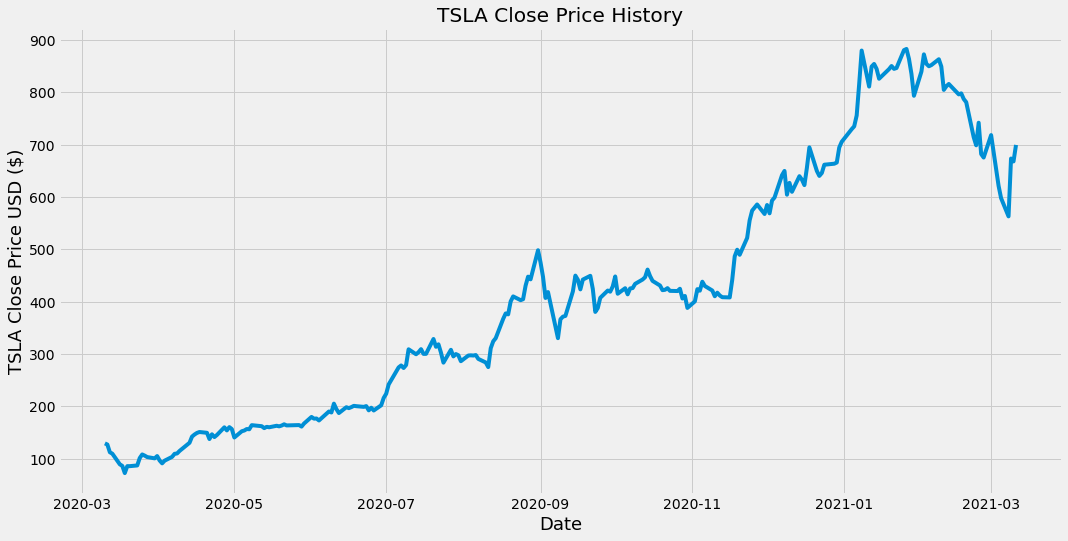

In [3]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title(f"{company} Close Price History")
plt.xlabel('Date',fontsize=18)
plt.ylabel(f"{company} Close Price USD ($)",fontsize=18)

plt.plot(df['Close'])
plt.show()

In [4]:
#Create a new dataframe with only the 'Close column'
data = df.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of data that we have)
training_data_len = math.ceil(len(dataset)*.8) #Math.ceil to round up

training_data_len

204

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

#Computes min and max value to be used for scaling, then transforms the data based on the min max values
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07007741],
       [0.06733954],
       [0.04916593],
       [0.04573001],
       [0.0206821 ],
       [0.01701432],
       [0.        ],
       [0.01638288],
       [0.01635575],
       [0.01802315],
       [0.03546419],
       [0.04391215],
       [0.04117675],
       [0.03777289],
       [0.03475629],
       [0.04015066],
       [0.02968257],
       [0.02300066],
       [0.02930026],
       [0.0382366 ],
       [0.04544142],
       [0.04627758],
       [0.05223679],
       [0.07146363],
       [0.08600152],
       [0.09091985],
       [0.09471343],
       [0.09685439],
       [0.09499707],
       [0.0802865 ],
       [0.09148222],
       [0.08495078],
       [0.0897655 ],
       [0.10791938],
       [0.10061097],
       [0.1083535 ],
       [0.1037583 ],
       [0.0838877 ],
       [0.09865499],
       [0.1003865 ],
       [0.10393096],
       [0.10330444],
       [0.11301776],
       [0.11101244],
       [0.11054873],
       [0.10599793],
       [0.10904906],
       [0.108

In [6]:
#Create the training data set
prediction_days = 60

#Create a scaled training data set, 0 up to 80% of allocated data
train_data = scaled_data[0:training_data_len, :]

#Split the data into x_train and y_train data sets
#Independent training variable, list of 60 closing prices that is going to be used to predict next day closing price in y_train
x_train = []
#Dependent training variable, list of next day closing prices corresponding to each list in x_train to be predicted by LSTM
y_train = [] 

#Append past 60 values of the train_data
for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i,0]) 
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
#Reshape the data, as LSTM requires a 3-dimensional input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(144, 60, 1)

In [8]:
#Building the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))  #Number of layers, we can adjust
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
          
model.add(Dense(units=1)) #Prediction of the next closing value
          
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
#Training the LSTM model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
5/5 [==============================] - 4s 50ms/step - loss: 0.1294
Epoch 2/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0247
Epoch 3/100
5/5 [==============================] - 0s 47ms/step - loss: 0.0123
Epoch 4/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0178
Epoch 5/100
5/5 [==============================] - 0s 51ms/step - loss: 0.0090
Epoch 6/100
5/5 [==============================] - 0s 50ms/step - loss: 0.0133
Epoch 7/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0075
Epoch 8/100
5/5 [==============================] - 0s 51ms/step - loss: 0.0084
Epoch 9/100
5/5 [==============================] - 0s 52ms/step - loss: 0.0074
Epoch 10/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0063
Epoch 11/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0067
Epoch 12/100
5/5 [==============================] - 0s 50ms/step - loss: 0.0080
Epoch 13/100
5/5 [==============================]

In [10]:
#Create the testing data set

#Creating new array contained scaled values 
test_data = scaled_data[training_data_len - prediction_days: , :]


x_test = []
y_test = dataset[training_data_len: , :] #Containing values our model want to predict

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i,0])#Append the past 60 values to test dataset
    
#Converting into numpy array to use in LSTM model
x_test = np.array(x_test)

In [11]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(50, 60, 1)

In [12]:
#Get the predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [13]:
#Getting RMSE to see how accurate the LSTM model is in predicting the closing price
rmse = np.sqrt(((predictions - y_test) ** 2).mean())
rmse

71.41519718211659

C:\Users\User\AppData\Local\Temp\ipykernel_3024\3073188831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


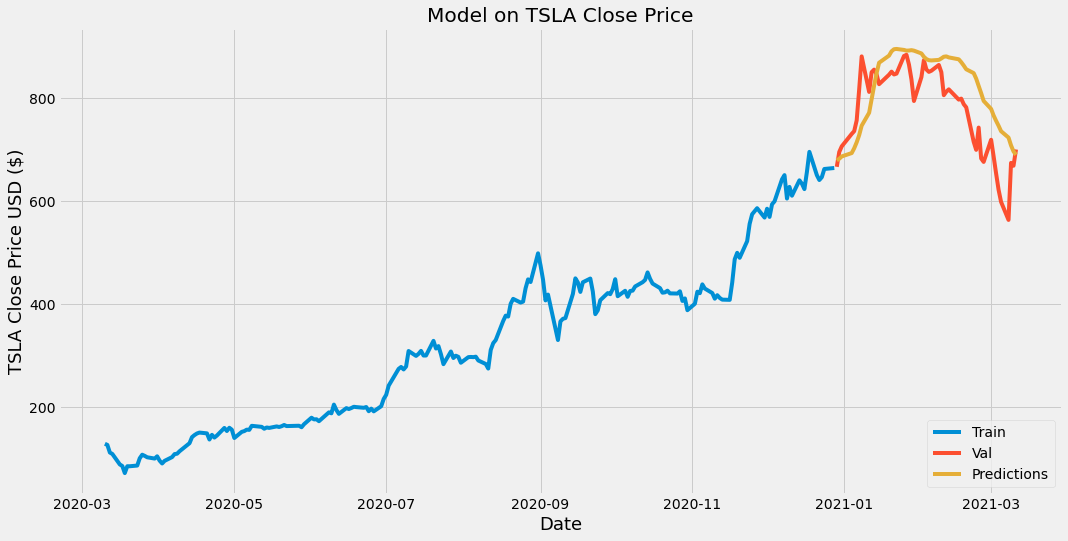

In [14]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualise the model
plt.figure(figsize=(16,8))
plt.title(f"Model on {company} Close Price")
plt.xlabel('Date',fontsize=18)
plt.ylabel(f"{company} Close Price USD ($)",fontsize=18)

plt.plot(train['Close']) 
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')

In [15]:
valid

,Close,Predictions
Date,,
2020-12-29,665.989990,678.466431
2020-12-30,694.780029,681.574097
2020-12-31,705.669983,686.113770
2021-01-04,729.770020,692.630310
2021-01-05,735.109985,701.910706
2021-01-06,755.979980,713.519226
2021-01-07,816.039978,727.412048
2021-01-08,880.020020,745.669556
2021-01-11,811.190002,770.804626


In [16]:
#Setting up the data before predicting future price

#Get quote
quote = web.DataReader(company, data_source='yahoo', start='2021-01-01', end='2022-03-20')

#Create a new dataframe
new_df = quote.filter(['Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list
X_test = []

#Append the past 60 days to X_test list
X_test.append(last_60_days_scaled)
              
#Convert the X_test data set to a numpty array
X_test = np.array(X_test)
              
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = model.predict(X_test)

#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[879.73474]]


In [17]:
#Predicted future price (next day)

quote2 = web.DataReader(company, data_source='yahoo', start='2022-03-21', end='2022-03-21')
print(tsla_quote2['Close'])

NameError: name 'tsla_quote2' is not defined